Загружаем область для выполнения анализа

In [1]:
import sklearn.datasets as ds

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# Проверяем наличие выбросов целевой переменной
def show_boxplot(df, columns=[]):
    df = df.loc[:, columns]
    sns.boxplot(x="variable", y="value", data=pd.melt(df))
    plt.show()

# Возвращаем счет RMSE и R2
def getRMSE_R2(Y_test, Y_pred):
    MSE = np.square(np.subtract(Y_test, predictions)).mean() 
    return math.sqrt(MSE), r2_score(Y_test, predictions)

# Выводим корреляционную матрицу
def show_correlation_map(df):
    cor = calif_df.corr()
    plt.figure(figsize=(16,9))
    sns.heatmap(cor, center=0, cmap="winter", annot = True)
    plt.show()

RMSE_array = []
R2_array = []

Загружаем дату калифорнии, проверяем целевую переменную на выбросы

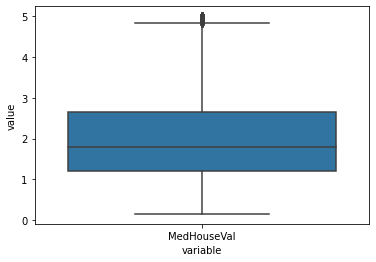

In [2]:
california_bunch = ds.fetch_california_housing()
data = np.c_[california_bunch.data, california_bunch.target]
columns = np.append(california_bunch.feature_names, california_bunch.target_names)
calif_df = pd.DataFrame(data, columns=columns)

show_boxplot(calif_df, columns = ['MedHouseVal'])

Учитывать верхние значение как выбросы нет необходимости. Значения в норме

Построим модель линейной регрессии. Посчитаем метрики качества RMSE и R2

In [3]:
X = calif_df.loc[:, calif_df.columns != 'MedHouseVal']
Y = calif_df['MedHouseVal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
linearRegression = LinearRegression()
linearRegression.fit(X_train, Y_train)
predictions = linearRegression.predict(X_test)
RMSE, R2 = getRMSE_R2(Y_test, predictions)
RMSE_array.append(RMSE)
R2_array.append(R2)
print("R2: ", R2)
print("Root Mean Square Error: ", RMSE)

R2:  0.5916360874211659
Root Mean Square Error:  0.7301644308101626


Выведем матрицу корреляции значений

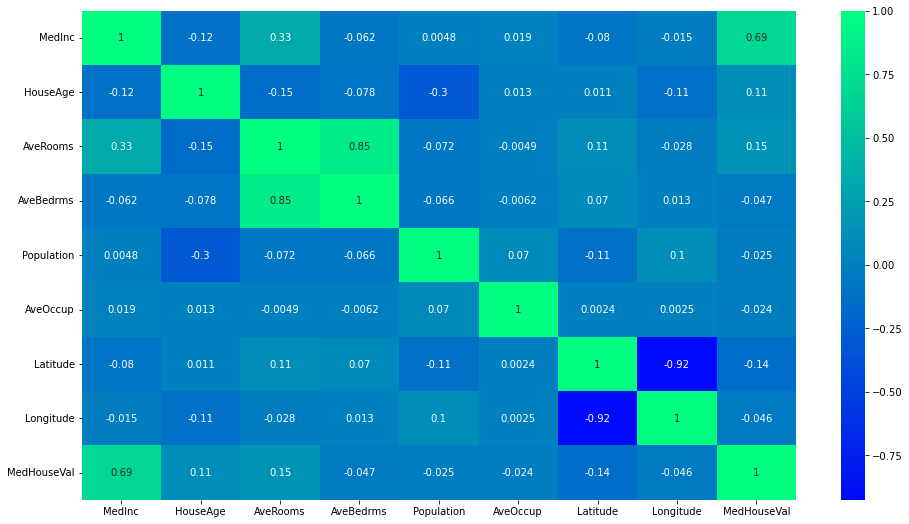

In [4]:
show_correlation_map(calif_df)

На целевой показатель влияют три параметра: 'MedInc', 'HouseAge', 'AveRooms'.
Построим модель для трех показателей и посчитаем метрики.

In [5]:
cuted_df = calif_df.loc[:, ['MedInc', 'HouseAge', 'AveRooms', 'MedHouseVal']]
X = cuted_df.loc[:, cuted_df.columns != 'MedHouseVal']
Y = cuted_df['MedHouseVal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
linearRegression = LinearRegression()
linearRegression.fit(X_train, Y_train)
predictions = linearRegression.predict(X_test)
RMSE, R2 = getRMSE_R2(Y_test, predictions)
RMSE_array.append(RMSE)
R2_array.append(R2)
print("R2: ", R2)
print("Root Mean Square Error: ", RMSE)

R2:  0.5168404799569519
Root Mean Square Error:  0.8083842643660285


Найдем выбросы по трем параметрам. Видно что параметр 'AveRooms' имеет выбросы в значениях больше ~15.

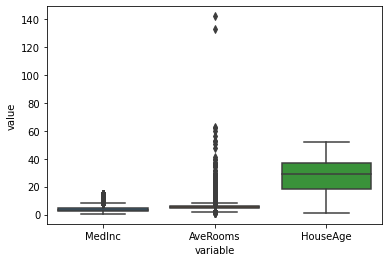

In [6]:
show_boxplot(cuted_df, columns = ['MedInc', 'AveRooms', 'HouseAge'])

Удаляем выбросы по среднему кол-ву комнат больше 15. Построим модель и посчитаем метрики.

In [7]:
cuted_df = cuted_df[cuted_df['AveRooms']<=15]
X = cuted_df.loc[:, cuted_df.columns != 'MedHouseVal']
Y = cuted_df['MedHouseVal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
linearRegression = LinearRegression()
linearRegression.fit(X_train, Y_train)
predictions = linearRegression.predict(X_test)
RMSE, R2 = getRMSE_R2(Y_test, predictions)
RMSE_array.append(RMSE)
R2_array.append(R2)
print("R2: ", R2)
print("Root Mean Square Error: ", RMSE)

R2:  0.5309334304655854
Root Mean Square Error:  0.7962779012074526


Попробуем трансформировать данные путем вычисления логарифма и корня из значений: 'HouseAge', 'MedInc'.

In [8]:
transformed_df = cuted_df
transformed_df['HouseAge'] = transformed_df.apply(lambda x: math.log(x['HouseAge']), axis=1)
transformed_df['MedInc'] = transformed_df.apply(lambda x: math.sqrt(x['MedInc']), axis=1)
X = transformed_df.loc[:, transformed_df.columns != 'MedHouseVal']
Y = transformed_df['MedHouseVal']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
linearRegression = LinearRegression()
linearRegression.fit(X_train, Y_train)
predictions = linearRegression.predict(X_test)
RMSE, R2 = getRMSE_R2(Y_test, predictions)
RMSE_array.append(RMSE)
R2_array.append(R2)
print("R2: ", R2)
print("Root Mean Square Error: ", RMSE)

R2:  0.5171867599978415
Root Mean Square Error:  0.8093064565192049


Построим графики по показателям RMSE и R2 четырех моделей линейной регрессии.

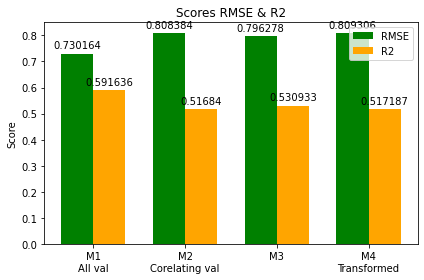

In [9]:
labels = ['M1\nAll val', 'M2\nCorelating val', 'M3\n', 'M4\nTransformed']
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, RMSE_array, width, label='RMSE',color='green')
rects2 = ax.bar(x + width/2, R2_array, width, label='R2', color='orange')
ax.set_ylabel('Score')
ax.set_title('Scores RMSE & R2')
ax.set_xticks(x, labels)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show()

Из графика видно, что выбор наиболее коррелируемых значенний к целевому и удаление выбросов повышает качетво модели.
Трансформация значений положительный результат в данном случае не дала.